In [1]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

/tmp/ipykernel_11159/2196755265.py:19: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
[Qibo 0.1.12.dev0|INFO|2024-06-13 07:32:38]: Using numpy backend on /CPU:0


In [2]:
'''Qibo_code_cell'''

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion import jordan_wigner, count_qubits

# NOTA: Haciendo este código me ha salido un error interno de las librerías de pyscf.
# Este error alega que no existe un módulo llamado openfermion.chem
# Esto puede deberse a que la versión de openfermion esté en una versión no compatible.
# Para solucionarlo, basta con ir al script de la función de pyscf y cambiar el comando
# from openfermion.chem import *
#   por
# from openfermion import *

In [3]:
'''Qibo_code_cell'''

# Creamos la molécula con los parámetros requeridos

# Parámetros moleculares
bond_length = 1.40104295
multiplicity = 1    # Dependiendo del tipo de molécula, el spin queda determinado por la multiplicidad. Si lo detecta como incompatible, dará error.
basis = 'sto-3g'
charge = 0

# Especificamos los elementos y su disposición geométrica
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]

# Parámetros del cálculo. En nuestro caso especificamos solo run_scf porque nos basta con haber hecho solo Hartree-Fock.
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 0
run_fci = 0
delete_input = True
delete_output = True

# Inicializamos la estructura molecular
molecule = MolecularData(geometry, basis, multiplicity,
                         charge, description=str(bond_length))

# Calculamos sus integrales
molecule = run_pyscf(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)



In [4]:
'''Qibo_code_cell'''

def qibo_mol_H(molecule):

    # molecule es una estructura molecular de OpenFermion
    # devuelve un Hamiltoniano en términos de Qibo

    # Obtenemos el Hamiltoniano molecular de nuestra molécula fabricada con OpenFermion
    H = molecule.get_molecular_hamiltonian()

    # Nos aseguramos de que el término constante está bien definido
    if H.constant is None: H.constant = 0

    # Hacemos la transformación de Jordan Wigner
    JW = jordan_wigner(H)
    dim = count_qubits(JW)

    # Inicializamos el operador con el término constante
    operator = JW.constant * reduce(np.kron, [m.I]*dim)  

    # Recorremos los términos del operador de Jordan-Wigner
    for index in JW.terms.keys():
        if index == ():
            continue # Omitimos el término constante, ya que hemos inicializado con él

        # Definimos una lista auxiliar de operadores identidad del tamaño del sistema
        lis = [m.I]*dim

        # Reemplazamos en nuestra lista los operadores en la posición en la que indica el término de JW
        for tag in index:
            if tag[1] == 'X': lis[tag[0]] = m.X
            elif tag[1] == 'Y': lis[tag[0]] = m.Y
            elif tag[1] == 'Z': lis[tag[0]] = m.Z

        # Sumamos el término JW a nuestro operador matricial
        operator += JW.terms[index] * reduce(np.kron, lis)

    return hamiltonians.Hamiltonian(dim, operator), dim, operator

In [5]:
'''Qibo_code_cell'''

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

op_H, n, mat = qibo_mol_H(molecule)

nqubits = n
nlayers  = 8

circuit = models.Circuit(nqubits)

for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
    
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))

In [6]:
'''Qibo_code_cell'''

# Optimizador
# opt = 'COBYLA'
opt = 'Powell'

In [7]:
'''Qibo_code_cell'''

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(p):
    intermediate_info['parameters'].append(p)
    
    energy, _, _ = vqe.minimize(p, callback = None, method=opt, options = None, compile=False)
    
    intermediate_info['energy'].append(energy)
    
    #intermediate_info['stddev'].append(stddev)

In [8]:
'''Qibo_code_cell'''

# Parámetros del Ansatz
initial_parameters = np.random.uniform(-2*np.pi, 2*np.pi, 2*nqubits*nlayers + nqubits)

# Construcción del método VQE
vqe = models.VQE(circuit, op_H)
options = {'disp': True, 'return_all': True}

# Y ejecutamos el algoritmo
best, params, extra = vqe.minimize(initial_parameters, callback = callback, method=opt, options = options, compile=False)

Optimization terminated successfully.
         Current function value: -1.015272
         Iterations: 5
         Function evaluations: 3090


In [9]:
# Vemos el valor al que convergemos
print('E_G =',best)

E_G = -1.0152715222551367


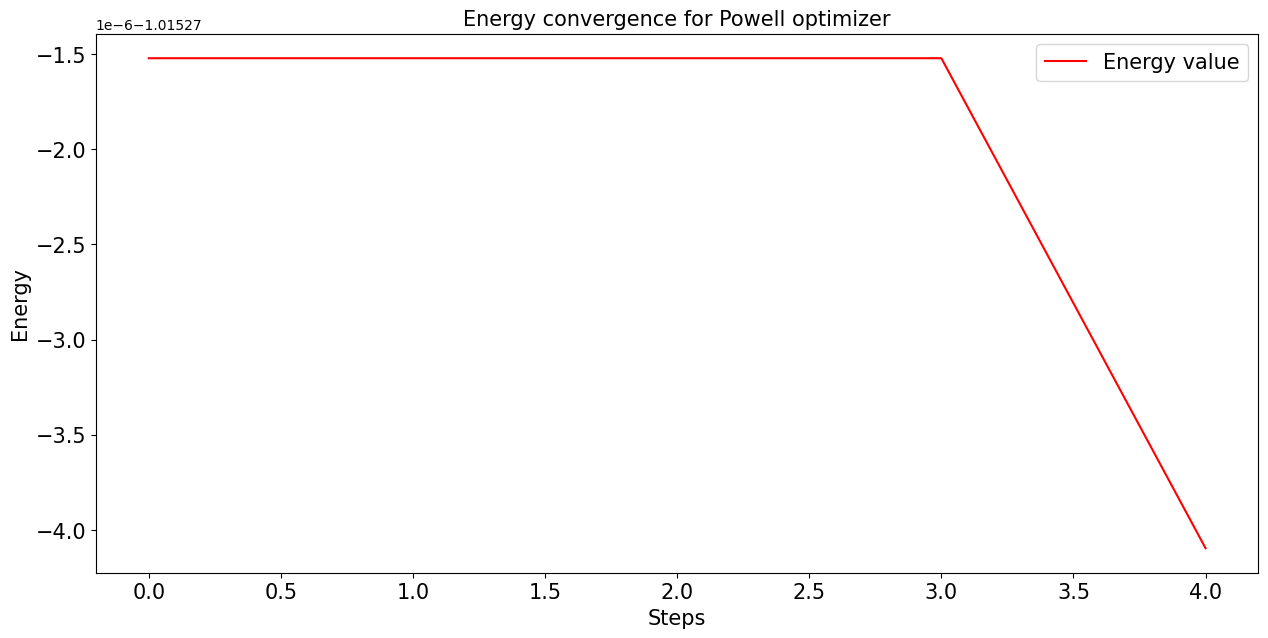

In [10]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

sim_values = intermediate_info['energy']
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_values)), sim_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Powell optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()